In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from definitions import ROOT_DIR
from unc.utils import load_info

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [23]:
level = 8
# all_paths = {
# #     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
#     f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn'),
#     f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn_lstm'),
# }
# results_dir = Path(ROOT_DIR, 'results')
results_dir = Path(ROOT_DIR, 'results', 'results_uf8_12m_hparam')

# results_dir = Path(ROOT_DIR, 'results_full_uf8')

all_paths = {
    f'uf{level}a_cnn': results_dir / f'uf{level}a_cnn',
    f'uf{level}m_cnn':  results_dir / f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm':  results_dir / f'uf{level}m_cnn_lstm',
}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth'},
    f'uf{level}m_cnn_lstm': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_unc': {'color': wisteria, 'label': 'LSTM + Aux inputs'},
    f'uf{level}m_cnn': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_unc': {'color': pumpkin, 'label': 'Aux inputs'}
}

plot_order = [
    f'uf{level}a_cnn',
    f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm',
    f'uf{level}m_cnn_unc',
    f'uf{level}m_cnn_lstm_unc'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc', 'total_steps']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [29]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
        if args['trunc'] > 10:
            continue
        
        if args['total_steps'] < 12e6:
            continue
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 4e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [30]:
def group_by(dataset, key, label_head, groups=None, add_labels=None):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)

        if groups is not None:
            assert add_labels is not None and len(add_labels) == len(groups)
            full_label = label_head
            grouped = False
            none_idx = None
            
            for i, g in enumerate(groups):
                add_label = False
                
                if g is not None and key_val in g:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}' 
                    grouped = True
                    break
                elif g is None:
                    none_idx = i
                    
            if not grouped:
                if none_idx is None:
                    print(f"skipping {key_val}")
                else:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}'
        else:     
            full_label = label_head + f'_{key}_{key_val}'
            
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data


In [31]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

In [32]:
arg_example = list(raw_data[f'uf{level}m_cnn'].values())[0][0][2]
steps_per_eval = arg_example['offline_eval_freq']

In [33]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
unc_decay_groups = [[1.], None]
additional_labels = [None, 'unc']

new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file, groups=unc_decay_groups, add_labels=additional_labels)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [34]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [35]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [36]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [37]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_unc': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.65, slip_prob=0.1, trunc=10, total_steps=12000000),
  28.91948,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn/3e0e2e288ddb0e4c5c039fb3671930d9_Fri Jun 17 12:41:11 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn/80e1f72b889195651486c802f8ef13d3_Fri Jun 17 12:41:12 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn/cacd37547b2dc20afe1e44dc741ec763_Fri Jun 17 12:46:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn/4cd4e5d9b55c7fcfb4597129b74ce477_Mon Jun 20 13:20:54 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn/d4c48bb21034e282463ff4f942d2ab43_Fri Jun 17 12:41:11 2022.npy')]),
 'uf8m_cnn': (args(buffer_size=100000, step_size=1e-06, a

In [38]:
# copy_to = Path(ROOT_DIR, 'results_full_uf8')
# for arg, tup in all_best_slip.items():
#     f_lst = tup[-1]
#     specific_dir = arg
#     if arg.endswith('_unc'):
#         specific_dir = specific_dir[:-4]
#     copy_to_specific = copy_to / specific_dir
#     copy_to_specific.mkdir(exist_ok=True)
#     for f in f_lst:
#         shutil.copy(f, copy_to_specific)

In [39]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [40]:
all_mapped_data_slip

{'uf8m_cnn_unc': array([[19.36,  6.5 , 19.88, ..., 27.3 , 30.14, 27.74],
        [10.8 , 14.38,  6.2 , ..., 28.62, 30.56, 26.46],
        [ 5.18,  9.04, 12.82, ..., 28.72, 29.7 , 30.34],
        [15.86, 12.84, 17.8 , ..., 29.4 , 30.  , 31.6 ],
        [16.28, 15.02, 12.44, ..., 30.18, 26.14, 30.6 ]]),
 'uf8m_cnn': array([[19.74, 13.24, 15.36, ..., 20.8 , 18.72, 21.94],
        [ 3.04,  3.24,  9.  , ..., 18.2 , 18.6 , 21.4 ],
        [ 7.88, 12.56,  9.36, ..., 28.54, 29.3 , 29.28],
        [ 8.98, 14.78, 15.7 , ..., 18.28, 23.32, 24.7 ],
        [ 4.74,  9.46, 11.22, ..., 23.18, 25.44, 25.46]]),
 'uf8m_cnn_lstm': array([[ 0.62,  1.62, 10.2 , ..., 33.34, 31.48, 28.88],
        [ 0.9 , 16.22, 17.84, ..., 19.1 , 21.08, 20.56],
        [ 2.02, 17.68, 20.52, ..., 21.34, 18.74, 22.1 ],
        [12.28, 12.7 , 14.06, ..., 30.36, 28.8 , 30.02],
        [ 7.36, 15.18, 14.92, ..., 21.  , 17.4 , 19.6 ]]),
 'uf8m_cnn_lstm_unc': array([[ 0.6 , 18.64, 18.2 , ..., 31.64, 30.2 , 32.74],
        [ 3.06, 

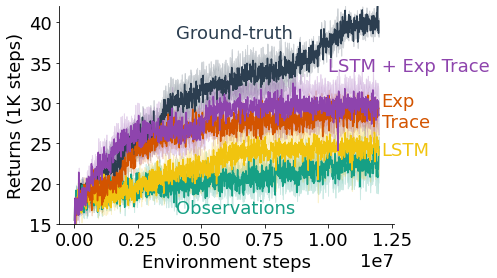

In [54]:
# with slip
fig, ax = plt.figure(), plt.axes()

fig_path = Path(ROOT_DIR, 'results', 'uf8_results.pdf')

for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(15, 42)
# ax.set_ylim(15, 30)

# ax.set_yticks([18, 22, 26])
ax.set_xlabel('Environment steps')
# ax.set_ylabel(f"Returns (1K steps)", rotation=0, labelpad=65)
ax.set_ylabel(f"Returns (1K steps)")
# ax.yaxis.set_label_coords(-0.15, 0.65)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.text(2e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))
plt.text(4e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 33.5, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
plt.text(4e6, 38, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
# plt.text(6.1e6, 24, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))
plt.text(12.1e6, 27, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))

# plt.text(6.1e6, 21.5, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))
plt.text(12.1e6, 23.5, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 27.5, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))
plt.text(10e6, 34, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))

# ax.set_title(f'Fishing Environment')

# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
fig.savefig(fig_path, bbox_inches='tight')



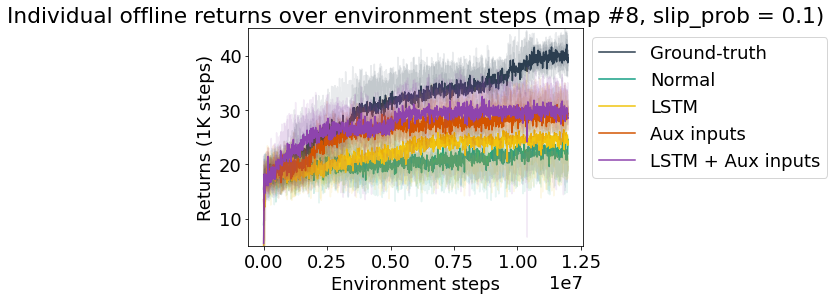

In [43]:
# with slip
fig, ax = plt.figure(), plt.axes()


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 45)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [55]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [56]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=500)


In [57]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5, total_steps=12000000),
  24.32292,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/485a11b2b588fbd3d79da77ac3f201f3_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/b3d5a1b2bf6c7a55c70922fe3447b5b8_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/6411d59853e18f4499e11a2843672ec3_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/82863906c675133dc79f7e5c9928e73c_Wed Jun 29 13:36:29 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/ae7af1329a72cfba94e4b68e1236a0f1_Wed Jun 29 13:46:25 2022.npy')]),
 'uf8m_cnn_lstm_trun

In [58]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


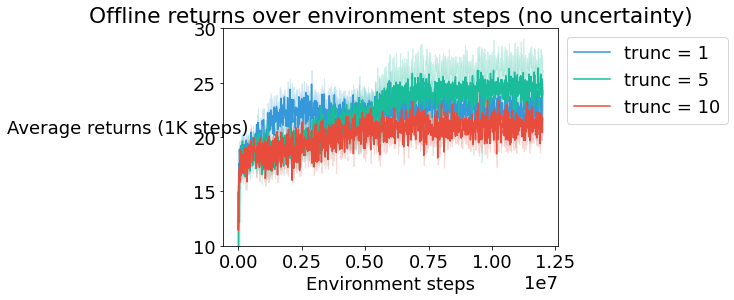

In [64]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': turquoise, 'label': 'trunc = 15'},
#     f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': 'trunc = 20'}

}

fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_ylim(10, 30)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_92503/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_92503/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_92503/614333861.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


KeyError: 'uf8m_cnn_lstm_trunc_20'

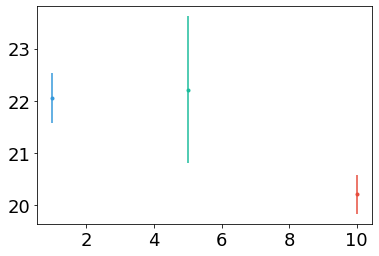

In [60]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [61]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=5, total_steps=12000000),
  29.644016000000004,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/eb6c44879c55b0e1be93228d5c02c353_Wed Jun 29 13:46:25 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/82eb4a9ff4d1f4502f38e5c8d5729c76_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/61432838d6884ecfeefe262afe2ae87a_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/a3bbe5cc86de7488ba9310196ba46c4a_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/c5fe2cc6247224637bf0f5591f1ffeef_Wed Jun 29 13:55:32 2022.npy')]),
 'uf8m_cn

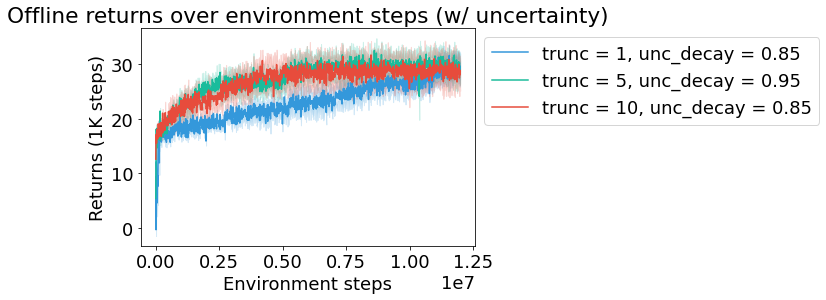

In [63]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
#     f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': f'trunc = 20, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_20"][0].uncertainty_decay}'}

}


fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [22.44626667 24.88583333 22.91356667 25.11383333 24.8914    ]
k: 5, step_means: [18.31803333 26.52813333 23.3031     24.36843333 26.384     ]
k: 10, step_means: [27.30666667 26.94873333 20.35773333 23.40593333 27.0667    ]
k: 20, step_means: [20.45543333 27.4392     25.0735     18.15283333 18.03536667]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_44752/28

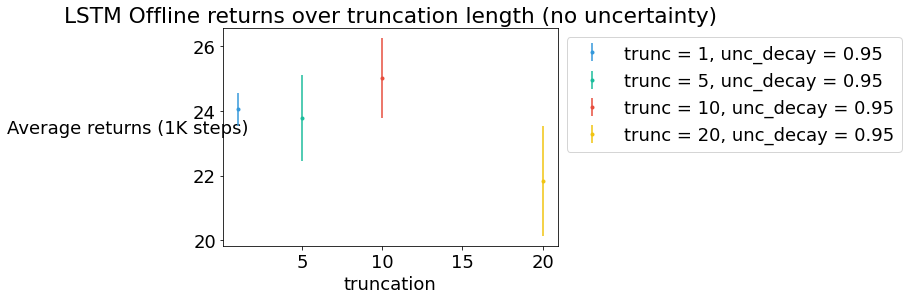

In [80]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')